In [1]:
from python_server_FCEUX import Server
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2

In [2]:
server = Server()

Waiting connection from emulator...
Connected:  <socket.socket fd=1216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 12345), raddr=('127.0.0.1', 58603)>


In [3]:
def jsonsMode(string):
    a = string.decode()
    return json.loads(a)

In [ ]:
'''
Get pixeis image.
params: {(int) down_sample -> 1, (int) len_max_x -> 255, (int) len_max_y -> 239, (int) len_min_x -> 1,
(int) len_min_x -> 1, (bool) grayscale -> False}

'''
image = server.sendCommandAndReceiveOperation(json.dumps({'operation': 'getScreenShot',
          'params': {
              'grayscale': True,
              'down_sample': 4,
              'len_min_y': 45,
              'len_max_y': 230
          }
      }))
print('LenImage: {}'.format(len(image)))
print(image)
#printImage(image)

In [ ]:
a = image.decode()
b = a.split('json')[1]
c = json.loads(b)
d = c['matriz']
e = np.asarray(d, dtype=np.int16)
plt.imshow(e, cmap='gray')
plt.show()

In [ ]:
'''
    Press Joypad
'''
import time
import random
begin = time.time()
images = []
i = 0
while True:
    try:
        print("I: {}".format(i))
        data = server.step('right', grayscale=True, downsample=2, min_y=45, max_y=230)
        js = jsonsMode(data)
        d = js['matriz']
        e = np.asarray(d, dtype=np.int16)
        if js['endgame'] != 8:
            print('END')
            server.reset('Super_Mario_Bros.fc1', grayscale=True, downsample=2, min_y=45, max_y=230)
        i+=1
    except Exception as e:
        print('Except: {}'.format(e))
        break
    
end = time.time()
print(end - begin)
print('I: {}'.format(i))


In [4]:
def chooseAction(number):
    return ['down', 'left', 'right', 'A', 'B'][number]

In [9]:
js = jsonsMode(data)
d = js['matriz']
e = np.asarray(d, dtype=np.int16)
plt.imshow(e, cmap='gray')

AttributeError: 'NoneType' object has no attribute 'decode'

In [3]:
for i in range(200):
    op = server.step('right', grayscale=True, downsample=4, min_y=45, max_y=230)


Requisitando novamente timed out


tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf
['/device:GPU:0']
Waiting connection from emulator...
Connected:  <socket.socket fd=3872, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 12345), raddr=('127.0.0.1', 50758)>
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 19, 32)        8224      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)      

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_7/convolution (defined at C:\Users\mateu\AppData\Local\Continuum\anaconda3\envs\MachineLearning01\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_894]

Function call stack:
keras_scratch_graph


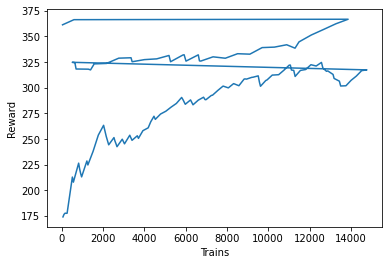

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 26 10:10:11 2020

@author: mateu
"""

import gym
import cv2
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
import os
import random
import matplotlib.pyplot as plt
import pickle
import time
import imageio
from python_server_FCEUX import Server


######################################################################################################################################
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

print(_get_available_gpus())
tfback._get_available_gpus = _get_available_gpus

####VERIFY IF GPU IS RUNNING.
#print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import keras

import tensorflow.compat.v1 as tf1

'''
config = tf1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
'''

######################################################################################################################################

import numpy as np
import tensorflow as tf

'''
 ' Huber loss.
 ' https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
 ' https://en.wikipedia.org/wiki/Huber_loss
'''
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

score = []

TRAIN = True
OBSERVER = 100
UPDATE_TARGET_MODEL = 1000
qntUpdate=0
tamMemoryK = 150 # O tamanho da memoria será esse valor multiplicado por 1000.

game = 'SuperMarioBross'
diretorioInProcess = "./currentProcessICMinih/"+game+"/"
total_reward_game = []
data_average_reward = []
trainsPerEpisode = []

class Agent(): 
    def __init__(self, state_size, action_size,):
        self.weight_backup      = diretorioInProcess+game+".h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=tamMemoryK*1000) if TRAIN else deque(maxlen=5)
        self.learning_rate      = 0.0005
        self.gamma              = 0.97
        self.exploration_rate   = .4
        self.exploration_min    = 0.05
        self.exploration_decay  = 1.0e-5
        self.k_frames           = 4
        self.frame_height       = self.state_size[0]
        self.frame_width        = self.state_size[1]
        self.brain              = self._build_model()
        self.brain_target       = self._build_model()


    def _build_model(self):
        with tf.device('/gpu:0'):
            # Neural Net for Deep-Q learning Model
            model = Sequential()
                
            #Criar camada de convolução.
            #-> (32,84,84,4)
            model.add(Conv2D(32, (8,8), strides=4,  input_shape = (self.state_size[0], self.state_size[1], self.k_frames) , activation = 'relu', padding='valid'))
            #<- (84,84)
            #->(84,84)
            #model.add(MaxPooling2D(pool_size = (2,2), dim_ordering='th'))
            #<-(42,42)
            #->(42,42)
            model.add(Conv2D(64, (4,4), strides=2, activation = 'relu', padding='valid'))
            #<-(42,42)
            #->(42,42)
            #model.add(MaxPooling2D(pool_size = (2,2)))
            #<-(21,21)
            #->(21,21)
            model.add(Conv2D(64, (3,3), strides=1, activation = 'relu', padding='valid'))
            #model.add(MaxPooling2D(pool_size = (2,2)))
            #<-(11,11)
            #model.add(Conv2D(512, (7,7), strides=1, activation = 'relu', padding='same'))
            #model.add(MaxPooling2D(pool_size = (2,2)))
            model.add(Flatten())
            
            #Criação da rede Neural.
            model.add(Dense(512, activation='relu'))
            #model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
            #model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
            #model.add(Dropout(.5))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss=huber_loss_mean, optimizer=Adam(lr=self.learning_rate))
        model.summary()
        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
            self.load_data()
        return model
    
    def load_data(self):
        global data_average_reward, total_reward_game, trainsPerEpisode
        if os.path.isdir(diretorioInProcess):
            with open(diretorioInProcess+"avarageProcess.txt", "rb") as avarageDocument:
                data_average_reward = pickle.load(avarageDocument)
            with open(diretorioInProcess+"lastRewards.txt", "rb") as lastRewards:
                total_reward_game = pickle.load(lastRewards)
            with open(diretorioInProcess+"trainsPerEpisode.txt", "rb") as trainsPerEpisodeDocument:
                trainsPerEpisode = pickle.load(trainsPerEpisodeDocument)
    
            print('LastRewards: {}'.format(total_reward_game))
            print('Average: {}'.format(data_average_reward))
            
            input()
    
    def save_model(self, avarageList, lastRewards, trainsPerEpisode):   
       
        if not os.path.isdir(diretorioInProcess):
            os.makedirs(diretorioInProcess)
            
        self.brain.save(self.weight_backup)
         
        with open(diretorioInProcess+"avarageProcess.txt", "wb") as avarageDocument:
            pickle.dump(avarageList, avarageDocument)
            
        with open(diretorioInProcess+"lastRewards.txt", "wb") as lastRewardsDocument:
            pickle.dump(lastRewards, lastRewardsDocument)
        
        with open(diretorioInProcess+"trainsPerEpisode.txt", "wb") as trainsPerEpisodeDocument:
            pickle.dump(trainsPerEpisode, trainsPerEpisodeDocument)
        
        
    def get_last_k_frames(self, state):
        frames = np.empty((self.k_frames, self.frame_height, self.frame_width))

        for i in range(0, self.k_frames):
            _, _, _, n_s, _ = self.memory[len(self.memory)-(self.k_frames-i)]
            frames[i] = n_s
            
        #frames[3] = state  
        return np.transpose(frames, axes=(1,2,0))

    def act(self, state):
        if np.random.rand() <= self.exploration_rate or len(self.memory) < self.k_frames+1:
            return random.randrange(self.action_size)
        
        k_frames_state = self.get_last_k_frames(state)
        k_frames_state = np.expand_dims(k_frames_state, axis=0)
        act_values = self.brain.predict(k_frames_state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):        
        self.memory.append((state, action, reward, next_state, done))

    
    def pack_K_frames(self, sample_batch_size):
        
        if len(self.memory) < self.k_frames+2:
            return
        
        state = np.empty((sample_batch_size, self.k_frames, self.frame_height, self.frame_width))
        action = np.empty(sample_batch_size, dtype=np.uint8)
        reward = np.empty(sample_batch_size, dtype=np.float32)
        next_state = np.empty((sample_batch_size, self.k_frames, self.frame_height, self.frame_width))
        done = np.empty(sample_batch_size, dtype=np.bool)
        
        for k in range(sample_batch_size):
            index = random.randint(0, len(self.memory)-self.k_frames-2)
            for i, idx_memory in enumerate(range(index, index+self.k_frames)):
                s, a, r, n_s, d = self.memory[idx_memory]
            
                state[k][i] = s
                next_state[k][i] = n_s
                
            done[k] = d
            action[k] = a
            reward[k] = r
    
        #State = (32,4,84,84)  -> State Transpose = (32,84,84,4) 
        return np.transpose(state, axes=(0,2,3,1)), action, reward, np.transpose(next_state, axes=(0,2,3,1)), done
        

    def replay(self, sample_batch_size):
       
        if len(self.memory) < sample_batch_size:
            return
        
        #sample_batch = random.sample(self.memory, sample_batch_size)
        state, action, reward, next_state, done = self.pack_K_frames(sample_batch_size)
        
        #print('State: {}'.format(state.shape))
        #print('Action: {}'.format(action.shape))
        #print('Reward: {}'.format(reward.shape))
        #print('Next_State: {}'.format(next_state.shape))
        #print('Done: {}'.format(done.shape))
        #input()
        #target = reward
        predicted = self.brain_target.predict(next_state) #Previsão proximo estado.
        target_f = self.brain.predict(state) #Previsão estado atual.
        #print('Predicted: {}'.format(predicted))
        #print('Predicted[0]: {}'.format(predicted[2]))
        #print('Predicted Max: {}'.format(np.amax(predicted)))
        #print('Reward: {}'.format(reward))
        #print('Target_f: {}'.format(target_f))
        #input()
        
        for i in range(sample_batch_size):
            target = reward[i] + (self.gamma * np.amax(predicted[i]) * (1-done[i]))
            target_f[i][action[i]] = target
            #print('Action: {}'.format(action[i]))
            #print('target: {}'.format(target))
            #print('target_f: {}'.format(target_f[i]))
            #input()
            
        
        #print('Target_f Formatado: {}'.format(target_f))
        #input()
        history = self.brain.fit(state, target_f, batch_size=sample_batch_size, epochs=1, verbose=0)
            
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate -= self.exploration_decay
    
        return history, self.exploration_rate

    def update_target_model(self, frame_number):
        if (frame_number % UPDATE_TARGET_MODEL == 0 and TRAIN and frame_number > OBSERVER):
            self.brain_target.set_weights(self.brain.get_weights())
            global qntUpdate
            qntUpdate+=1
            print('-------------------------UPDATED TARGET MODEL({}) ------------------------------'.format(qntUpdate))


class Nintendo():
    
    def __init__(self):
        self.env = Server()
        self.sample_batch_size = 32
        self.episodes = 5000000
        self.action_size = 3
        self.state_size = (80,80)
        self.agent = Agent(self.state_size, self.action_size)
        self.number_print = 0
        self.best_score = -99999999
        self.replay_bestPlay = deque(maxlen=300)
        self.crop_on_top = 35 #57
        self.crop_on_bottom = 15
        self.crop_on_border = 7
        self.frame_number=0
        self.freq_update=4
        self.qnt_train=0
        self.epochs_to_save = 50
        self.time_train_init = time.time()

        self.frames_in_atual_episode=0
        self.seconds_in_atual_episode=0
    
    def actions(self,n):
        if n > 5:
            print('Numero maior que quantidade de buttões')
            return
        return ['left', 'right', 'A'][n]
    
    def restart_chronometer(self):
        self.frames_in_atual_episode=0
        self.seconds_in_atual_episode=0
    
    def get_frames_per_seconds_in_atual_episode(self):
        return int(self.frames_in_atual_episode / (time.time() - self.seconds_in_atual_episode))
    
    def to_gray_scale(self, img):
        return 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]
    
    def down_sample(self, img):
        return img[::2,::2]
    
    def preprocess_img(self, img):        
        new_image = cv2.resize(np.asarray(img, dtype=np.float32)/ 255, self.state_size, interpolation=cv2.INTER_AREA)
        '''plt.imshow(new_image)
        plt.show()
        print('Shape: {}'.format(new_image.shape))
        input()'''
        return new_image
        
    def crop_img(self, img):
        #return img[self.crop_on_top: -self.crop_on_bottom, self.crop_on_border:-self.crop_on_border]
        return img[35:195, 8:-8]
  
    def transform_reward(self, reward):
        return np.sign(reward)
      
    def formatTimeBr(time):
        horas = time/3600
        minutos = (time%3600)/60
        segundos = (time%3600)%60
        
        return str('{}hr : {}min : {}seg'.format(horas, minutos, segundos))
    
    def save_image_epoch(self, gif_to_save, epoch, r):
        
        if (r == 1):
            diretorio = diretorioInProcess+'/movies/'
            if not os.path.isdir(diretorio):
                os.makedirs(diretorio)
                
            frames_per_seconds_gif = 60
            seconds = len(gif_to_save)/frames_per_seconds_gif
    
            imageio.mimwrite(diretorio+str(epoch)+'.mp4', gif_to_save , fps = 75)
            print('Gif Salvo') 
            
    def run(self):
        global total_reward_game, data_average_reward, trainsPerEpisode
    
        try:
            for i_episodes in range(self.episodes):
                js = self.env.reset('unnecessary',grayscale=True, downsample=2, min_y=45, max_y=230)
                state = js['matriz']
               
                state = self.preprocess_img(state)
                
                done = False
                atual_epoch = []
                total_reward=0
                history_list = []
                exploration = 1.0
                self.seconds_in_atual_episode= time.time()
                last_reward = 0
                
                while not done:
                                        
                    #if i_episodes > 600 or not TRAIN:
                    #self.env.render()
                    action = self.agent.act(state)
                    js = self.env.step(self.actions(action), grayscale=True, downsample=2, min_y=45, max_y=230)
                    next_state = js['matriz']
                    if js['reward'] > last_reward:
                        reward = 1
                    elif js['reward'] == last_reward:
                        reward = 0
                    else:
                        reward = -1
                    last_reward = js['reward']
                    done = True if js['endgame'] != 8 else False
                    
                    total_reward+=reward
                    #self.replay_bestPlay.append(next_state)
                    #if total_reward >= 5:
                    #    self.smile_for_the_photo()
                    #if (i_episodes % self.epochs_to_save == 0):
                    #    atual_epoch.append(np.asarray(next_state))
                    next_state = self.preprocess_img(next_state)
                    self.agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    
                    self.frame_number+=1
                    self.frames_in_atual_episode+=1
                    if TRAIN:
                        if self.frame_number > OBSERVER and self.frame_number % 4 == 0:
                            history, exploration = self.agent.replay(self.sample_batch_size)
                            history_list.append(history.history['loss'])    
                            self.qnt_train+=1
                        
                        self.agent.update_target_model(self.frame_number)
    
                total_reward_game.append(total_reward)
                mediaUltimosJogos = np.mean(total_reward_game[-50:])
                trainsPerEpisode.append(self.qnt_train)
                data_average_reward.append(mediaUltimosJogos)
                if TRAIN and self.frame_number > OBSERVER:
                    #self.save_image_epoch(atual_epoch, i_episodes, reward)   
                    if mediaUltimosJogos > self.best_score and self.frame_number > OBSERVER:
                            self.best_score = mediaUltimosJogos
                            self.agent.save_model(data_average_reward, total_reward_game, trainsPerEpisode)
                            print('Save -> ', end='')
                print("Episode {}# r: {}# Average: {:.3}# Loss: {:.6} # Train: {} # eps: {:.3}# Space: {}% 'fps: {}:".format(i_episodes, total_reward, data_average_reward[len(data_average_reward)-1], np.mean(history_list), self.qnt_train, exploration, round(((len(self.agent.memory) / (tamMemoryK*1000)) * 100), 2), self.get_frames_per_seconds_in_atual_episode() ))
                self.restart_chronometer()
        finally:
            plt.plot(trainsPerEpisode, data_average_reward)
            plt.xlabel('Trains')
            plt.ylabel('Reward')
            
            #plt.title('Time of train: (Minih) {}'.format(time.time() - self.time_train_init))
            #print(self.formatTimeBr((time.time() - s\elf.time_train_init)))
            if TRAIN:
                self.agent.save_model(data_average_reward, total_reward_game, trainsPerEpisode)
            plt.savefig('atualGraph.png')
            
if __name__ == '__main__':
    nintendo = Nintendo()
    nintendo.run()

In [2]:
a = np.asarray(((1,2,3), (3,2,1)), dtype=np.float32)/10

In [10]:
lista = [1,2,3,4,5]
lista.reverse()
print(lista)

[5, 4, 3, 2, 1]
